## Why Synthetic Data?

When developing forecasting solutions you often need to answer questions
like:

- **"How does my model handle sudden demand spikes?"** (e.g. from
  promotions or viral events)
- **"Which model is most robust to heavy-tailed distributions?"** (e.g.
  insurance claims, website traffic)
- **"How do different models behave with multiple seasonalities?"** (e.g.
  daily + weekly + yearly patterns)

Real-world data is messy, expensive to obtain, and you can't control its
characteristics. With synthetic data:

1. **You know the ground truth** — you designed the data generation
   process.
2. **You can isolate specific behaviours** — test one characteristic at a
   time.
3. **You can generate unlimited samples** — no data-scarcity issues.
4. **Reproducibility** — same seed = same data, every time.

## Setup

In [ ]:
import sys
from pathlib import Path

# When running from the nbs/ directory of a development checkout,
# ensure the local source tree takes precedence over an installed version.
_repo_root = str(Path.cwd().parent) if Path.cwd().name == "nbs" else str(Path.cwd())
if _repo_root not in sys.path:
    sys.path.insert(0, _repo_root)

# Purge any cached utilsforecast modules so the local version loads
for _key in list(sys.modules):
    if _key.startswith("utilsforecast"):
        del sys.modules[_key]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.synthetic import TimeSeriesSimulator

## Basic Usage: Built-in Distributions

`TimeSeriesSimulator` ships with seven built-in distributions:
`normal`, `poisson`, `exponential`, `gamma`, `uniform`, `binomial`,
`lognormal`.

In [3]:
sim = TimeSeriesSimulator(
    length=100,
    distribution="normal",
    dist_params={"loc": 100, "scale": 15},
    seed=42,
)

df = sim.simulate(n_series=3)
print(f"Generated {df['unique_id'].nunique()} series with {len(df)} total rows")
df.head(10)

Generated 3 series with 300 total rows


,unique_id,ds,y
0,0,2020-01-01,104.570756
1,0,2020-01-02,84.400238
2,0,2020-01-03,111.256768
3,0,2020-01-04,114.108471
4,0,2020-01-05,70.734472
5,0,2020-01-06,80.467307
6,0,2020-01-07,101.917606
7,0,2020-01-08,95.256361
8,0,2020-01-09,99.747983
9,0,2020-01-10,87.204341


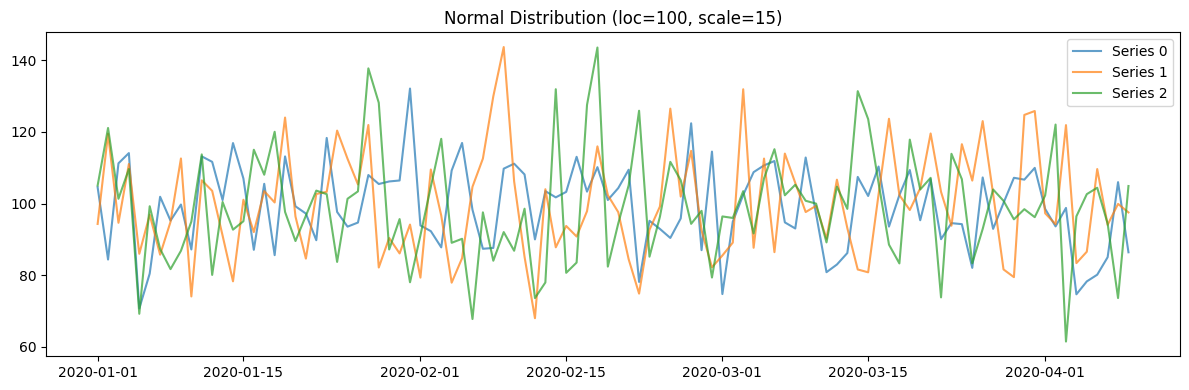

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
for uid in df["unique_id"].unique():
    subset = df[df["unique_id"] == uid]
    ax.plot(subset["ds"], subset["y"], label=f"Series {uid}", alpha=0.7)
ax.set_title("Normal Distribution (loc=100, scale=15)")
ax.legend()
plt.tight_layout()
plt.show()

## Adding Trend and Seasonality

Real time series often have trend and seasonal components.
`TimeSeriesSimulator` supports:

**Trends:** `linear`, `quadratic`, `exponential`, or any custom callable.

**Seasonality:** single or multiple periods.

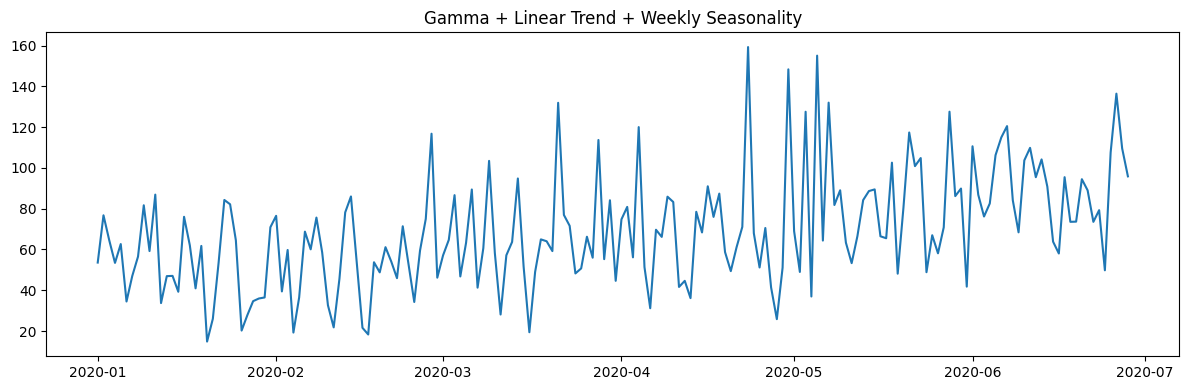

In [5]:
sim = TimeSeriesSimulator(
    length=180,
    distribution="gamma",
    dist_params={"shape": 5, "scale": 10},
    trend="linear",
    trend_params={"slope": 0.2, "intercept": 0},
    seasonality=7,
    seasonality_strength=15.0,
    seed=42,
)

df = sim.simulate()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["ds"], df["y"])
ax.set_title("Gamma + Linear Trend + Weekly Seasonality")
plt.tight_layout()
plt.show()

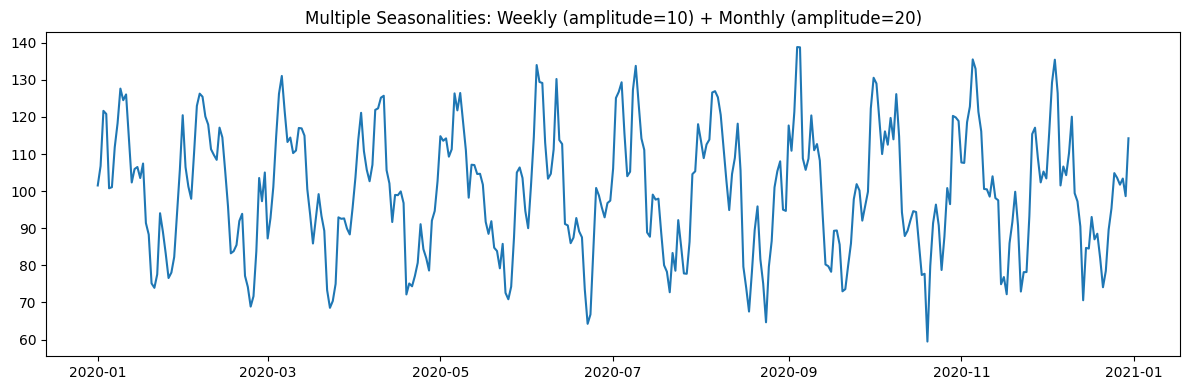

In [6]:
sim = TimeSeriesSimulator(
    length=365,
    distribution="normal",
    dist_params={"loc": 100, "scale": 5},
    seasonality=[7, 30],
    seasonality_strength=[10.0, 20.0],
    seed=42,
)

df = sim.simulate()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["ds"], df["y"])
ax.set_title("Multiple Seasonalities: Weekly (amplitude=10) + Monthly (amplitude=20)")
plt.tight_layout()
plt.show()

## The Key Feature: Custom Distributions

**This is why `TimeSeriesSimulator` exists.**

Built-in distributions are useful, but real-world data often has complex
patterns that don't fit standard distributions. The `distribution`
parameter accepts any callable with signature:

```python
def my_distribution(size: int, rng: np.random.Generator) -> np.ndarray:
    # Generate `size` values using `rng` for reproducibility
    return values
```

This gives you **complete control** over the data-generation process.

### Example 1: Demand with Promotional Spikes

In retail forecasting, demand usually follows a gamma-like distribution,
but promotional events cause sudden spikes. How do different models
handle this?

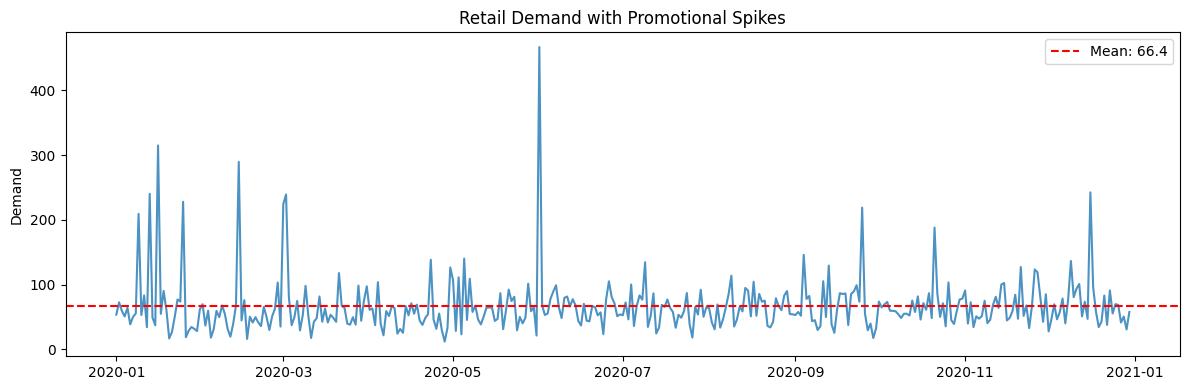

Normal range: 27.8 – 125.8
Max (spike):  466.8


In [7]:
def demand_with_spikes(size, rng):
    """Simulate retail demand with random promotional spikes."""
    base_demand = rng.gamma(shape=5, scale=10, size=size)
    spike_mask = rng.random(size) < 0.05  # 5% of days have spikes
    spike_multiplier = rng.uniform(2.5, 5.0, size=size)
    demand = base_demand.copy()
    demand[spike_mask] *= spike_multiplier[spike_mask]
    return demand


sim = TimeSeriesSimulator(
    length=365,
    distribution=demand_with_spikes,
    trend="linear",
    trend_params={"slope": 0.05},
    seasonality=7,
    seasonality_strength=10.0,
    seed=42,
)

df = sim.simulate(n_series=1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["ds"], df["y"], alpha=0.8)
ax.axhline(
    df["y"].mean(), color="red", linestyle="--",
    label=f"Mean: {df['y'].mean():.1f}",
)
ax.set_title("Retail Demand with Promotional Spikes")
ax.set_ylabel("Demand")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Normal range: {df['y'].quantile(0.05):.1f} – {df['y'].quantile(0.95):.1f}")
print(f"Max (spike):  {df['y'].max():.1f}")

### Example 2: Bimodal Distribution (Two Customer Segments)

Imagine two customer segments with different spending patterns — some
spend ~\$20, others spend ~\$80.

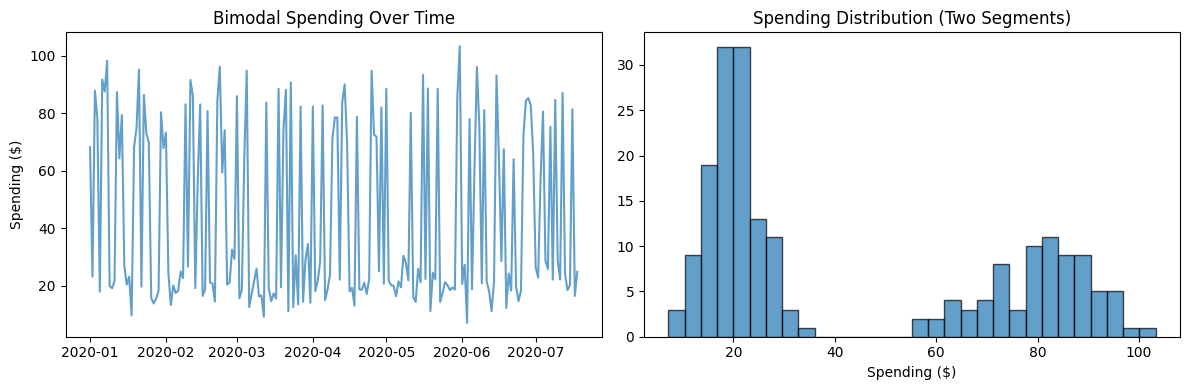

In [8]:
def bimodal_spending(size, rng):
    """Two customer segments with different spending patterns."""
    segment = rng.random(size) < 0.6  # 60 % low spenders
    values = np.zeros(size)
    values[segment] = rng.normal(20, 5, size=segment.sum())
    values[~segment] = rng.normal(80, 10, size=(~segment).sum())
    return np.maximum(values, 0)


sim = TimeSeriesSimulator(length=200, distribution=bimodal_spending, seed=42)
df = sim.simulate()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(df["ds"], df["y"], alpha=0.7)
axes[0].set_title("Bimodal Spending Over Time")
axes[0].set_ylabel("Spending ($)")
axes[1].hist(df["y"], bins=30, edgecolor="black", alpha=0.7)
axes[1].set_title("Spending Distribution (Two Segments)")
axes[1].set_xlabel("Spending ($)")
plt.tight_layout()
plt.show()

### Example 3: Regime Changes (Market Conditions)

Financial or economic data often exhibits regime changes — periods of low
volatility followed by high volatility.

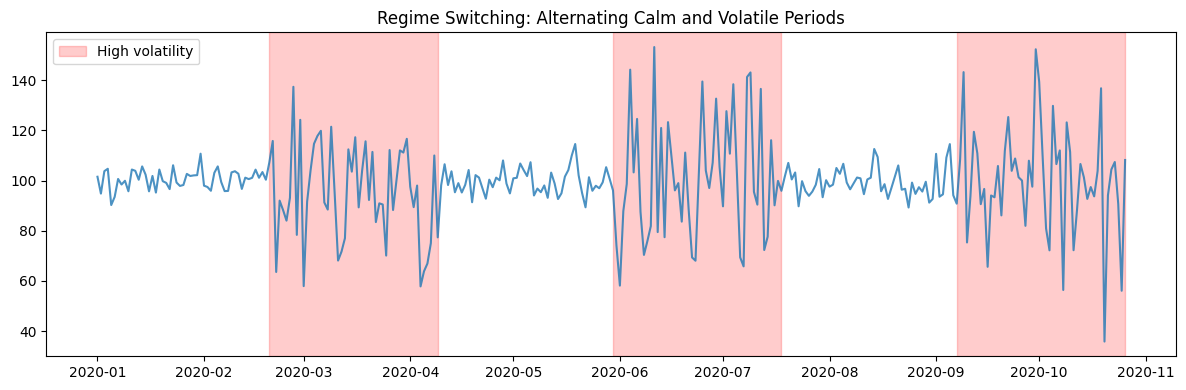

In [9]:
def regime_switching(size, rng):
    """Alternating regimes of low and high volatility."""
    values = np.zeros(size)
    regime_length = 50
    for i in range(0, size, regime_length):
        end = min(i + regime_length, size)
        segment_size = end - i
        if (i // regime_length) % 2 == 0:
            values[i:end] = rng.normal(100, 5, size=segment_size)
        else:
            values[i:end] = rng.normal(100, 25, size=segment_size)
    return values


sim = TimeSeriesSimulator(length=300, distribution=regime_switching, seed=42)
df = sim.simulate()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["ds"], df["y"], alpha=0.8)
for i in range(1, 6, 2):
    start_idx = i * 50
    end_idx = min((i + 1) * 50, 300)
    if start_idx < 300:
        ax.axvspan(
            df["ds"].iloc[start_idx],
            df["ds"].iloc[min(end_idx - 1, 299)],
            alpha=0.2, color="red",
            label="High volatility" if i == 1 else "",
        )
ax.set_title("Regime Switching: Alternating Calm and Volatile Periods")
ax.legend()
plt.tight_layout()
plt.show()

---

## Model Benchmarking with Cross-Validation

Now let's see the real power: **comparing how different models perform on
our custom distributions**.

We'll use StatsForecast's `cross_validation` method together with
`utilsforecast.evaluation.evaluate` to benchmark models on spike-prone
demand data.

> **Note:** The cells below require `statsforecast` to be installed.
> Install it with `pip install statsforecast` if you want to run them
> locally.

In [10]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, MSTL, SeasonalNaive

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, smape

/Users/indarkumar/Documents/Projects/utilsforecast_contri/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1 — Generate Synthetic Data with Spikes

Generated 10 series
Total observations: 2000
Date range: 2020-01-01 to 2020-07-18


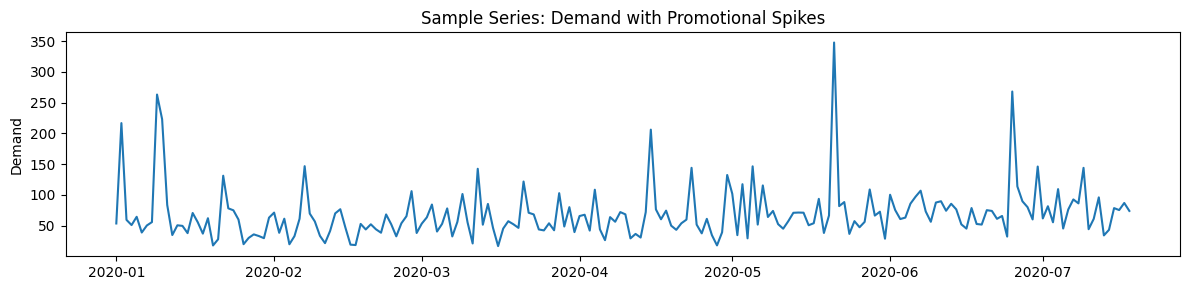

In [11]:
sim = TimeSeriesSimulator(
    length=200,
    distribution=demand_with_spikes,
    trend="linear",
    trend_params={"slope": 0.1},
    seasonality=7,
    seasonality_strength=10.0,
    seed=42,
)

df = sim.simulate(n_series=10)

print(f"Generated {df['unique_id'].nunique()} series")
print(f"Total observations: {len(df)}")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")

sample = df[df["unique_id"] == 0]
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sample["ds"], sample["y"])
ax.set_title("Sample Series: Demand with Promotional Spikes")
ax.set_ylabel("Demand")
plt.tight_layout()
plt.show()

### Step 2 — Cross-Validate Multiple Models

In [12]:
sf = StatsForecast(
    models=[
        SeasonalNaive(season_length=7),
        AutoETS(season_length=7),
        MSTL(season_length=7),
    ],
    freq="D",
    n_jobs=-1,
)

cv_results = sf.cross_validation(df=df, h=14, n_windows=3, step_size=14)
print(f"Cross-validation results shape: {cv_results.shape}")
cv_results.head(10)

Cross-validation results shape: (420, 7)


,unique_id,ds,cutoff,y,SeasonalNaive,AutoETS,MSTL
0,0,2020-06-07,2020-06-06,106.848147,28.835722,55.857199,57.529152
1,0,2020-06-08,2020-06-06,73.086512,100.261850,59.209669,62.404292
2,0,2020-06-09,2020-06-06,56.300717,75.407013,59.212616,66.907465
3,0,2020-06-10,2020-06-06,87.574524,60.754405,72.786666,68.483146
4,0,2020-06-11,2020-06-06,89.708019,63.126358,124.900913,139.616391
5,0,2020-06-12,2020-06-06,74.253285,85.768274,92.681534,76.865226
6,0,2020-06-13,2020-06-06,85.578057,97.041349,71.881745,70.699306
7,0,2020-06-14,2020-06-06,76.461381,28.835722,56.497851,58.249053
8,0,2020-06-15,2020-06-06,52.085925,100.261850,59.846140,63.072407
9,0,2020-06-16,2020-06-06,45.223739,75.407013,59.809234,67.527519


### Step 3 — Evaluate Model Performance

In [13]:
model_cols = [
    c for c in cv_results.columns
    if c not in ["unique_id", "ds", "cutoff", "y"]
]
print(f"Models evaluated: {model_cols}")

evaluation = evaluate(
    cv_results,
    metrics=[mae, rmse, smape],
    models=model_cols,
)

avg_metrics = evaluation.groupby("metric")[model_cols].mean()
print("\n=== Average Performance Across All Series ===")
avg_metrics

Models evaluated: ['SeasonalNaive', 'AutoETS', 'MSTL']

=== Average Performance Across All Series ===


,SeasonalNaive,AutoETS,MSTL
metric,,,
mae,31.300554,27.354959,26.744798
rmse,45.019729,38.111212,37.374833
smape,0.198778,0.173437,0.171913


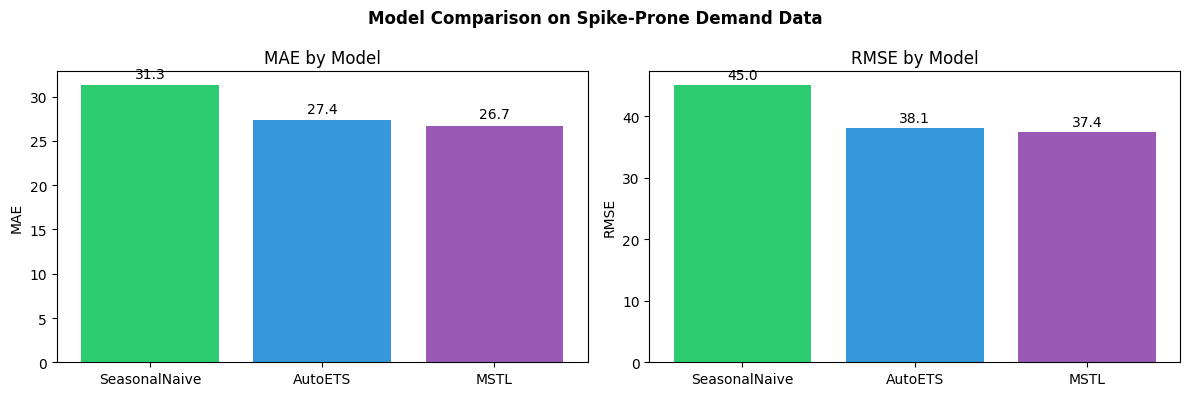

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ["#2ecc71", "#3498db", "#9b59b6"]

for idx, metric_name in enumerate(["mae", "rmse"]):
    if metric_name in avg_metrics.index:
        values = avg_metrics.loc[metric_name]
        bars = axes[idx].bar(values.index, values.values, color=colors)
        axes[idx].set_title(f"{metric_name.upper()} by Model")
        axes[idx].set_ylabel(metric_name.upper())
        for bar, val in zip(bars, values.values):
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,
                f"{val:.1f}",
                ha="center", va="bottom", fontsize=10,
            )

plt.suptitle(
    "Model Comparison on Spike-Prone Demand Data",
    fontsize=12, fontweight="bold",
)
plt.tight_layout()
plt.show()

### Step 4 — Compare Across Distribution Scenarios

The real insight comes from running the **same benchmark** on different
synthetic distributions and observing how model rankings change.

In [15]:
def benchmark_on_distribution(dist_func, seed=42):
    """Run a benchmark and return average MAE per model."""
    sim = TimeSeriesSimulator(
        length=200,
        distribution=dist_func,
        trend="linear",
        trend_params={"slope": 0.1},
        seasonality=7,
        seasonality_strength=10.0,
        seed=seed,
    )
    bench_df = sim.simulate(n_series=5)

    sf = StatsForecast(
        models=[
            SeasonalNaive(season_length=7),
            AutoETS(season_length=7),
            MSTL(season_length=7),
        ],
        freq="D",
        n_jobs=-1,
    )
    cv = sf.cross_validation(df=bench_df, h=14, n_windows=2, step_size=14)
    m_cols = [
        c for c in cv.columns if c not in ["unique_id", "ds", "cutoff", "y"]
    ]
    eval_df = evaluate(cv, metrics=[mae], models=m_cols)
    return eval_df[m_cols].mean()


def smooth_gamma(size, rng):
    """Smooth gamma — no spikes."""
    return rng.gamma(shape=5, scale=10, size=size)


def high_spike_demand(size, rng):
    """Higher spike probability (15 %)."""
    base = rng.gamma(shape=5, scale=10, size=size)
    mask = rng.random(size) < 0.15
    base[mask] *= rng.uniform(3.0, 6.0, size=mask.sum())
    return base

In [16]:
print("Running benchmarks on different distributions ...\n")

results = {}
for dist_func, name in [
    (smooth_gamma, "Smooth (No Spikes)"),
    (demand_with_spikes, "5 % Spikes"),
    (high_spike_demand, "15 % Spikes"),
]:
    print(f"  Benchmarking: {name}")
    results[name] = benchmark_on_distribution(dist_func)

print("\nDone!")

Running benchmarks on different distributions ...

  Benchmarking: Smooth (No Spikes)
  Benchmarking: 5 % Spikes
  Benchmarking: 15 % Spikes

Done!


In [17]:
comparison = pd.DataFrame(results).T
comparison.columns = [c.replace("-mae", "") for c in comparison.columns]
print("=== MAE by Distribution Type ===")
comparison

=== MAE by Distribution Type ===


,SeasonalNaive,AutoETS,MSTL
Smooth (No Spikes),22.871801,16.360211,17.420171
5 % Spikes,35.489318,30.000426,28.358479
15 % Spikes,69.865208,60.928513,53.247584


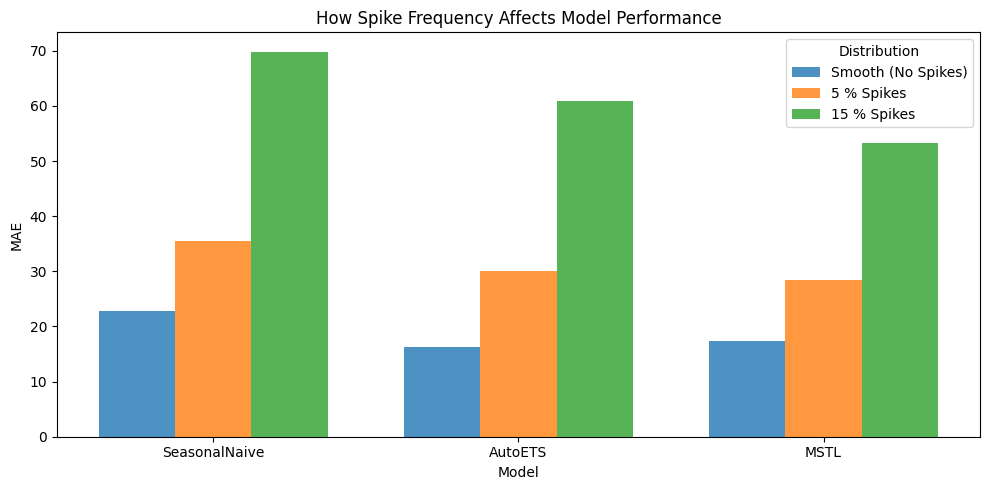

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(comparison.columns))
width = 0.25

for i, (dist_name, row) in enumerate(comparison.iterrows()):
    ax.bar(x + i * width, row.values, width, label=dist_name, alpha=0.8)

ax.set_xlabel("Model")
ax.set_ylabel("MAE")
ax.set_title("How Spike Frequency Affects Model Performance")
ax.set_xticks(x + width)
ax.set_xticklabels(comparison.columns)
ax.legend(title="Distribution")
plt.tight_layout()
plt.show()

### Key Insights

By using `TimeSeriesSimulator` with different custom distributions we
can systematically answer questions like:

1. **Which model is most robust to spikes?** Compare performance across
   spike frequencies.
2. **Does adding complexity help?** Compare simple (SeasonalNaive) vs
   complex (AutoARIMA) models.
3. **What is the cost of outliers?** Compare smooth vs spike-prone
   distributions.

This **controlled experimentation** is impossible with real-world data
alone.

---

## Summary

`TimeSeriesSimulator` enables systematic model evaluation by generating
synthetic data with:

| Feature | Options |
|---|---|
| **Distribution** | 7 built-in + any custom callable |
| **Trend** | linear, quadratic, exponential, custom |
| **Seasonality** | Single or multiple periods |
| **Noise** | Additional Gaussian noise |
| **Output** | Pandas or Polars DataFrame |

**Workflow:**

1. Define a custom distribution encoding domain knowledge (spikes,
   regimes, etc.).
2. Generate synthetic data with `TimeSeriesSimulator`.
3. Cross-validate multiple models with `StatsForecast` (or any Nixtla
   forecasting library).
4. Evaluate with `utilsforecast.evaluation.evaluate()`.
5. Compare results across distribution scenarios.

The custom callable interface lets you model domain-specific behaviours
that don't fit standard distributions, making your model benchmarks more
realistic and actionable.